# Model Owner

## Model Training

### Import dependencies

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import struct

### Directory to save machine learning model

In [2]:
current_dir = os.path.abspath('')
model_dir = os.path.join(current_dir, "data")
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

### Load and prepare dataset

In [3]:
# Import the Fashion MNIST dataset.
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Preprocess the data: Data normalization.
train_images = train_images / 255.0
test_images = test_images / 255.0

### Check dataset

In [4]:
# Explore the data.
len(test_labels)
# 10000
train_images.shape
# (60000, 28, 28)

(60000, 28, 28)

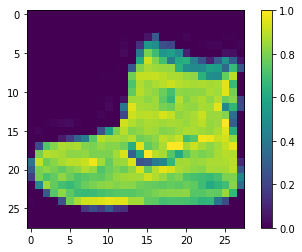

In [5]:
#  Plot one input image.
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

### Compile and train the model

In [ ]:
def train_model(train_images, train_labels):
    # Define Keras deep-learning model
    model = keras.Sequential(
        [
            keras.layers.Flatten(input_shape=(28, 28)),
            keras.layers.Dense(128, activation="relu"),
            keras.layers.Dense(10),
            keras.layers.Activation('softmax')
        ]
    )

    # Setup the model for training:
    # Loss function — This measures how accurate the model is during
    #                 training. You want to minimize this function to
    #                 "steer" the model in the right direction.
    # Optimizer — This is how the model is updated based on the data it
    #             sees and its loss function.
    # Metrics — Used to monitor the training and testing steps.
    #           The following example uses accuracy, the fraction of the
    #           images that are correctly classified.
    model.compile(
        optimizer="adam",
        loss=tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True),
        metrics=["accuracy"],
    )

    # Model training.
    model.fit(train_images, train_labels, epochs=10)


    return model


# Execute training.
model = train_model(train_images, train_labels)

# Save the model in SavedModel format, if needed.
model.save(os.path.join(model_dir,"MNIST_model_TF"), save_format="tf")

### Load a saved model (in case the model has already been trained and stored)

In [6]:
model = keras.models.load_model(os.path.join(model_dir,"MNIST_model_TF"))

### Evaluate model accuracy

In [7]:
test_loss, test_acc = model.evaluate(
    test_images, test_labels, verbose=2
)
print("\nTest accuracy:", test_acc)

10000/10000 - 0s - loss: 1.6564 - accuracy: 0.8048

Test accuracy: 0.8048


### Make a local single prediction

In [8]:
test_image = test_images[0:1, :, :]
prediction = model.predict(test_image)
prediction

array([[3.5808602e-17, 1.7985531e-15, 1.7203463e-16, 2.3079021e-13,
        4.0911916e-15, 4.5084374e-04, 1.1734944e-12, 6.0330509e-05,
        2.0615051e-11, 9.9948883e-01]], dtype=float32)

### Convert model to TFLite format

In [9]:
# In order to run the model in the Avato enclave it first needs
# to be converted into a simpler format called `TFLite`,
# also provided and maintained by Google.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model in flatbuffer format, if necessary
with open(os.path.join(model_dir, "MNIST.fb"), "wb") as f:
    f.write(tflite_model)

### Load a TFLite model (in case the model has already been converted and stored)

In [10]:
with open(os.path.join(model_dir, "MNIST.fb"), "rb") as f:
    tflite_model = f.read()

## Model Upload

### Import dependencies

In [11]:
from avato import Client
from avato import Secret
from avato_tflite_dynamic import TFLITEDYNAMIC_Instance

### Login to avato

In [12]:
model_owner_client = Client(
    username=os.environ["MODEL_OWNER_ID"],
    password=os.environ["MODEL_OWNER_PASSWORD"],
    instance_types=[TFLITEDYNAMIC_Instance],
    backend_host="avato-backend.westeurope.cloudapp.azure.com"
)
model_owner_client.reset_backend()

### Create instance

In [13]:
inference_user_id = os.environ["INFERENCE_USER_ID"]
model_owner_instance = model_owner_client.create_instance(
    "Inference Demo",
    TFLITEDYNAMIC_Instance.type,
    [inference_user_id],
)
print(model_owner_instance.id)

e9f5ead0-e814-4f48-8390-b12a182dfc88


### Check security guarantees

In [15]:
# Validating the fatquote. This step is crucial for all security
# guarantees.
# It gets and validates the cryptographic proof from the enclave:
#
# i)   It proves it is a valid SGX enclave (by checking a certificate).
# ii)  It compares the hash of the enclave code provided by the user to
#      an expected value (to verify what code is running in the enclave).
# iii) As part of the proof also a public key is transmitted that allows
#      establishing a secure connection into the enclave (as the private
#      key is only known to the enclave).
#
# As we are using a non-production environment, we whitelist debug and
# out_of_data flags

model_owner_instance.validate_fatquote(
    expected_measurement="958c8ed1ec4f5d818157acfc3b50a8d9306db94258d3e435abd5e96c72ee081c",
    accept_debug=True,
)

print(model_owner_instance.fatquote)

{
    "certificate": "-----BEGIN CERTIFICATE-----\nMIIEoTCCAwmgAwIBAgIJANEHdl0yo7CWMA0GCSqGSIb3DQEBCwUAMH4xCzAJBgNV\nBAYTAlVTMQswCQYDVQQIDAJDQTEUMBIGA1UEBwwLU2FudGEgQ2xhcmExGjAYBgNV\nBAoMEUludGVsIENvcnBvcmF0aW9uMTAwLgYDVQQDDCdJbnRlbCBTR1ggQXR0ZXN0\nYXRpb24gUmVwb3J0IFNpZ25pbmcgQ0EwHhcNMTYxMTIyMDkzNjU4WhcNMjYxMTIw\nMDkzNjU4WjB7MQswCQYDVQQGEwJVUzELMAkGA1UECAwCQ0ExFDASBgNVBAcMC1Nh\nbnRhIENsYXJhMRowGAYDVQQKDBFJbnRlbCBDb3Jwb3JhdGlvbjEtMCsGA1UEAwwk\nSW50ZWwgU0dYIEF0dGVzdGF0aW9uIFJlcG9ydCBTaWduaW5nMIIBIjANBgkqhkiG\n9w0BAQEFAAOCAQ8AMIIBCgKCAQEAqXot4OZuphR8nudFrAFiaGxxkgma/Es/BA+t\nbeCTUR106AL1ENcWA4FX3K+E9BBL0/7X5rj5nIgX/R/1ubhkKWw9gfqPG3KeAtId\ncv/uTO1yXv50vqaPvE1CRChvzdS/ZEBqQ5oVvLTPZ3VEicQjlytKgN9cLnxbwtuv\nLUK7eyRPfJW/ksddOzP8VBBniolYnRCD2jrMRZ8nBM2ZWYwnXnwYeOAHV+W9tOhA\nImwRwKF/95yAsVwd21ryHMJBcGH70qLagZ7Ttyt++qO/6+KAXJuKwZqjRlEtSEz8\ngZQeFfVYgcwSfo96oSMAzVr7V0L6HSDLRnpb6xxmbPdqNol4tQIDAQABo4GkMIGh\nMB8GA1UdIwQYMBaAFHhDe3amfrzQr35CN+s1fDuHAVE8MA4GA1UdDwEB/wQEAwIG\nwDAMBgNVHRMBAf8EAjAAMGAGA

In [16]:
#  The quote is part of the fatquote and provides a detailed fingerprint
#  of the program and state of the remote machine. For example:
#  * using `flags` we can detect if the CPU is running in un-trusted
#    debug mode
#  * using `*_snv` we can verify if all security patches have been
#    deployed to the infrastructure
#  * using `mrenclave` we can attest to the exact program being
#    executed on the remote machine
print(model_owner_instance.quote)

{
    "version": 2,
    "sign_type": 1,
    "qe_svn": 10,
    "pce_svn": 9,
    "xeid": 0,
    "epid_group_id": "7d0b0000",
    "basename": "ab9969abb88e6f7fab9c9a50e17c98ff00000000000000000000000000000000",
    "reportdata": "4cb2d57507098f973dd7df9d42738fde0f74b2c6433b9801bbdbf5d7a65749010000000000000000000000000000000000000000000000000000000000000000",
    "cpusvn": "0e0e0205ff8007000000000000000000",
    "mrenclave": "958c8ed1ec4f5d818157acfc3b50a8d9306db94258d3e435abd5e96c72ee081c",
    "mrsigner": "9affcfae47b848ec2caf1c49b4b283531e1cc425f93582b36806e52a43d78d1a",
    "isvprodid": 0,
    "isvsvn": 0,
    "flags": 7
}


### Creating (randomly) a public-private keypair and setting it

In [17]:
model_owner_secret = Secret()
model_owner_instance.set_secret(model_owner_secret)

### Uploading the model

In [18]:
# Before uploading, the model is encrypted using the enclave
# public key extracted from the fatquote.
# The model_owner public key also sent together with the encrypted data.
model_owner_instance.upload_model(tflite_model)

### Make a local single prediction

In [19]:
prediction_remote = model_owner_instance.predict(test_image)

### Comparison of results

In [20]:
# Notice the little difference due to the fact that the TFLite model
# uses 32-bit precision, (like most models), while the local prediction
# is done on 64-bit precision.
print(f"Local - Label: {prediction.argmax()} with weight: {prediction.max()}")
print(
    f"Remote - Label: {prediction_remote.argmax()} with weight: {prediction_remote.max()}"
)

Local - Label: 9 with weight: 0.9994888305664062
Remote - Label: 9 with weight: 0.9994888305664062


### Cleanup the enclave

In [21]:
model_owner_instance.delete()
assert model_owner_instance.id not in model_owner_client.get_instances()